In [1]:
import optax
import equinox as eqx
from jax import numpy as jnp, random as jr, vmap, nn

import numpy as np
from matplotlib import pyplot as plt

from pets.train import train
from pets.envs import AtariEnv
from pets.model import Ensemble
from pets.dataset import Dataset, Normalizer

In [2]:
def sample_episodes(env, dataset, num_episodes, max_steps):
    for _ in range(num_episodes):
        (state, _), done, step = env.reset(), False, 0
        while not done and step < max_steps:
            action = env.action_space.sample()
            next_state, reward, done, truncated, info = env.step(action)
            dataset.add(state, action, reward, next_state)
            state = next_state
            step = step + 1
    return dataset


def sample_trajectory(env, max_steps):
    (state, _), done, steps, trajectory = env.reset(), False, 0, []
    while not done and steps < max_steps:
        action = env.action_space.sample()
        next_state, reward, done, truncated, info = env.step(action)
        trajectory.append((state, action, reward, next_state))
        state = next_state
        steps = steps + 1
    states, actions, rewards, next_states = zip(*trajectory)
    return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states)

In [3]:
_tile = lambda x: jnp.tile(x[None, ...], (ensemble_dim, 1))

def forward(model, normalizer, state, action, key):
    inputs = jnp.concatenate([state, _tile(action)], axis=-1)
    inputs = normalizer.normalize(inputs)
    delta_mean, delta_logvar = model(inputs)
    delta_std = jnp.sqrt(jnp.exp(delta_logvar))
    delta = delta_mean + delta_std * jr.normal(key, delta_mean.shape)
    return state + delta


def rollout(model, normalizer, state, actions, key):
    states = []
    state = _tile(state)
    for action in actions:
        key, subkey = jr.split(key)
        state = forward(model, normalizer, state, action, subkey)
        states.append(state)
    return jnp.array(states)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


collected 100000 samples
loss: 462.08089122558596


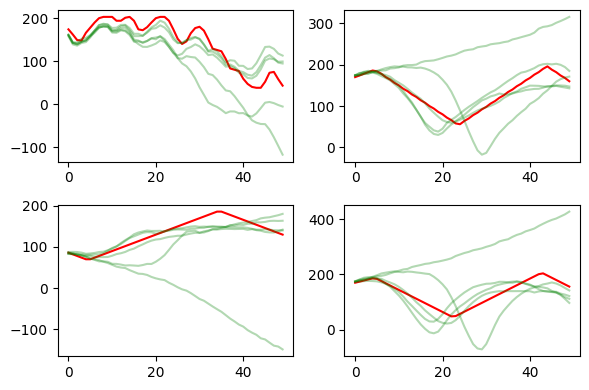

loss: 410.40585513305666


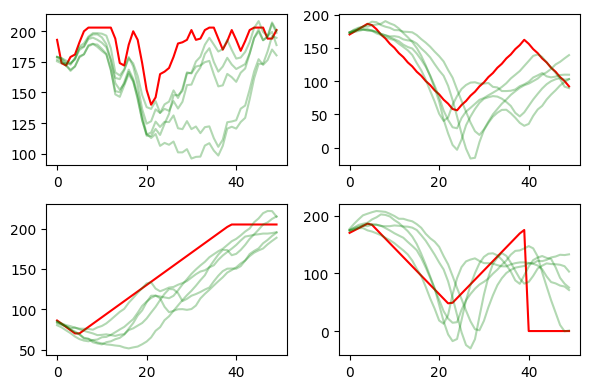

loss: 342.8588816174316


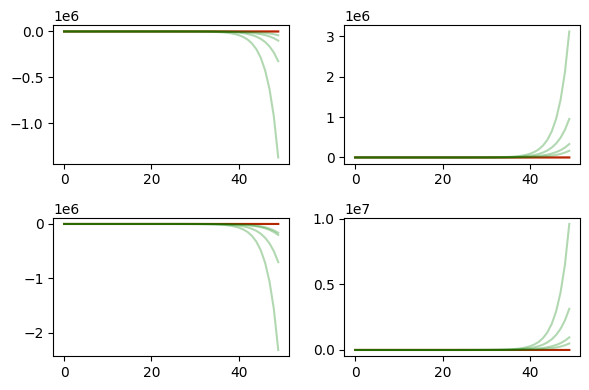

loss: 273.40919028808594


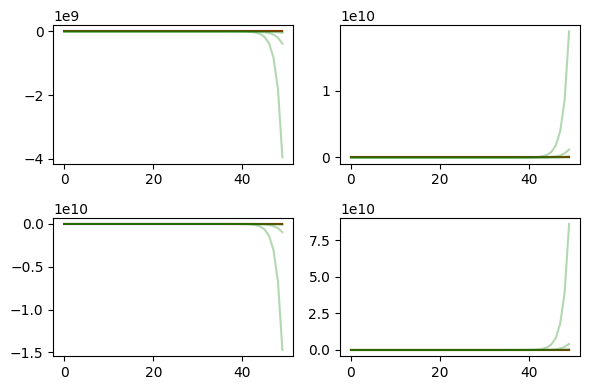

loss: 219.54450475341798


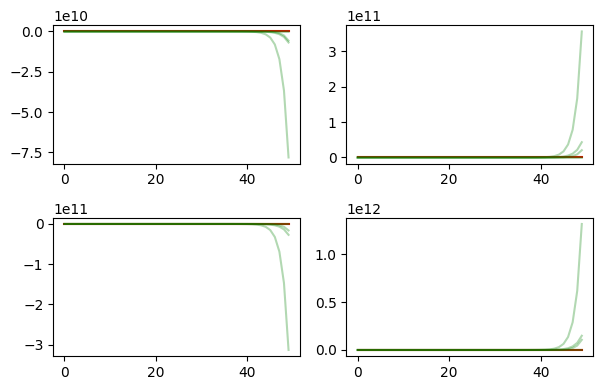

loss: 191.55260632263185


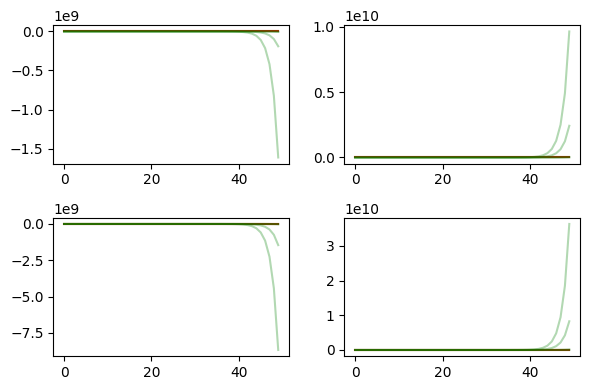

In [4]:
key = jr.PRNGKey(0)

""" hyper parameters """
batch_dim, hidden_dim, ensemble_dim = 32, 200, 5
num_random_episodes, num_train_epochs, max_steps, rollout_steps = 500, 5, 200, 50

""" environment """
env = AtariEnv("PongDeterministic-v4")
state_dim, action_dim = env.observation_space.shape[0], 1

""" dataset """
normalizer = Normalizer(state_dim + action_dim)
dataset = Dataset(state_dim, action_dim, ensemble_dim)

""" model """
key, subkey = jr.split(key)
model = Ensemble(state_dim + action_dim, state_dim, hidden_dim, ensemble_dim, key=subkey)
optim = optax.adamw(learning_rate=1e-4, weight_decay=1e-5, eps=1e-8)
optim_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

""" collect data """
dataset = sample_episodes(env, dataset, num_random_episodes, max_steps)
print(f"collected {len(dataset)} samples")

""" train model """
while True:
    key, subkey = jr.split(key)

    model, optim_state, losses = train(model, optim, optim_state, dataset, normalizer, batch_dim, num_train_epochs)
    print(f"loss: {losses[-1]}")

    states, actions, rewards, next_states = sample_trajectory(env, rollout_steps)
    states, actions = states[25:, :], actions[25:, :]
    preds = rollout(model, normalizer, states[0], actions, subkey)

    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    for idx, ax in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
        axes[ax].plot(states[:, idx], c="r")
        axes[ax].plot(preds[:, :, idx], c="g", alpha=0.3)
    plt.tight_layout()
    plt.show()

    eqx.tree_serialise_leaves("../data/model.eqx", model)
    normalizer.save("../data/normalizer.pkl")